In [30]:
import ee
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import interpolate
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [2]:
ee.Initialize()

### Get the pixel count 

In [3]:
# get the urban img
urban = ee.Image("users/wangjinzhulala/North_China_Plain_Python/classificatioin_temporal_checked/Mosaic_only_forward")
region = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_Boundary")

# mask out 0-value pixels
urban = urban.mask(urban.gte(1))

# get the pixel count of each year
urban_pix_count = urban.reduceRegion(reducer = ee.Reducer.frequencyHistogram(),
                                    geometry = region.geometry().convexHull(),
                                    scale = 30,
                                    maxPixels = int(1e13)).getInfo()['b1']

In [4]:
# define the pixel value that corespondind to the year
true_image_year_val = {f'{i+1}':f'{year}_{year+2}' for (i,year) in enumerate(range(2017,1989,-3))}


# get the urban growth-pixels count
pix_count_df = pd.DataFrame({true_image_year_val[str(i)]:[urban_pix_count[str(i)]] for i in range(10,0,-1)}).T

# accumulate the growth-pixels, then make the middle year as the date
pix_count_df['pix_count'] = pix_count_df[0].cumsum()
pix_count_df['year'] = range(1991,2019,3)
pix_count_df = pix_count_df[['year','pix_count']]
pix_count_df['area_km2'] = pix_count_df['pix_count']*30*30/1000/1000

In [5]:
# save data to disk
pix_count_df.to_csv('../Data/Result_csv/pix_count_df.csv',index=False)
pix_count_df = pd.read_csv('../Data/Result_csv/pix_count_df.csv')
pix_count_df

,year,pix_count,area_km2
0,1991,4.216937e+07,37952.428634
1,1994,5.361226e+07,48251.037734
2,1997,6.109841e+07,54988.567334
3,2000,6.681810e+07,60136.292834
4,2003,7.495013e+07,67455.119478
5,2006,8.480370e+07,76323.327212
6,2009,9.700969e+07,87308.719112
7,2012,1.109729e+08,99875.573912
8,2015,1.259419e+08,113347.685054
9,2018,1.464770e+08,131829.274264


### Exponetial fitting to predict to 2030

In [50]:
# get value for fiting
X = pix_count_df['year']
y = pix_count_df['pix_count']

ext_range = range(1991,2031,3)


# fit the urban pixel count, note the p0 were created from additional Excel Trend Line
coef,_ = curve_fit(lambda t,a,b: a*np.exp(b*t), X, y, p0=[1e-30,0.04])

# get the coefficients
fit_val = coef[0]*np.exp(coef[1]*pix_count_df['year'])
fit_val_ext = coef[0]*np.exp(coef[1]*ext_range)

# compute the R2
R2 = r2_score(y,fit_val)
R2

C:\ProgramData\Anaconda3\envs\python37\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.9970720928221682

In [56]:
coef

array([1.61005976e-30, 4.33059036e-02])

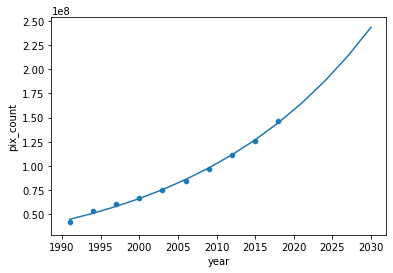

In [51]:
sns.lineplot(x=ext_range,y=fit_val_ext)
sns.scatterplot(x=X,y=y)

In [54]:
fit_ext_tf = pd.DataFrame(data={'year':ext_range,'pix_count':fit_val_ext})
fit_ext_tf['area_km2'] = fit_ext_tf['pix_count']*30*30/1000/1000
fit_ext_tf

,year,pix_count,area_km2
0,1991,4.493703e+07,40443.323991
1,1994,5.117135e+07,46054.215362
2,1997,5.827059e+07,52443.531919
3,2000,6.635474e+07,59719.268226
4,2003,7.556045e+07,68004.401437
5,2006,8.604330e+07,77438.969904
6,2009,9.798049e+07,88182.440152
7,2012,1.115738e+08,100416.402243
8,2015,1.270529e+08,114347.639078
9,2018,1.446796e+08,130211.621513


In [55]:
# save data to disk
fit_ext_tf.to_csv('../Data/Result_csv/fit_ext_tf.csv',index=False)
fit_ext_tf = pd.read_csv('../Data/Result_csv/fit_ext_tf.csv')
fit_ext_tf

,year,pix_count,area_km2
0,1991,4.493703e+07,40443.323991
1,1994,5.117135e+07,46054.215362
2,1997,5.827059e+07,52443.531919
3,2000,6.635474e+07,59719.268226
4,2003,7.556045e+07,68004.401437
5,2006,8.604330e+07,77438.969904
6,2009,9.798049e+07,88182.440152
7,2012,1.115738e+08,100416.402243
8,2015,1.270529e+08,114347.639078
9,2018,1.446796e+08,130211.621513


##### Exponetial Smoothing to predict the pix_count to 2030

In [118]:
# fit the pix_count using Expotential Smoothing
data = pix_count_df['pix_count'].values.tolist()
index = pd.date_range(start="1991", end="2019", freq="3A")

data_to_fit = pd.Series(data)
data_to_fit.index = index

# fit the data
fit_exp = Holt(data_to_fit, exponential=True, initialization_method="estimated")\
            .fit(smoothing_level=0.9, smoothing_trend=0.1, optimized=False)

fit_damp =Holt(data_to_fit, damped_trend=True, initialization_method="estimated")\
            .fit(smoothing_level=0.9, smoothing_trend=0.1)

fit_linear = Holt(data_to_fit, initialization_method="estimated")\
            .fit(smoothing_level=0.9, smoothing_trend=0.1, optimized=False)

fit_f = zip([fit_linear,fit_damp,fit_exp],['fit_linear','fit_damp','fit_exp'])

C:\ProgramData\Anaconda3\envs\python37\lib\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


In [119]:
# function to get simulations
def simulate_exp_fit(sim_f,sim_f_name,sim_num=100,forcast_len=5):
    # simulate the fitting for 100 times 
    simulations = sim_f.simulate(forcast_len, repetitions=sim_num, error="mul",anchor="2018-12-31")
    simulations.index = range(2018,2018+forcast_len*3,3)
    
    # simulate the exponetial smoothing
    sim = pd.DataFrame(simulations.stack()).reset_index()
    sim.columns = ['year','sim','pix_count']
    sim = sim[['year','pix_count']]
    sim['area_km2'] = sim['pix_count']*30*30/1000/1000

    # compute the ['mean','count','std']
    sim_agg = sim.groupby(['year']).agg(['mean','count','std']).reset_index()
    sim_agg.columns = [i+'_'+j for i,j in sim_agg.columns]

    # rename columns
    sim_agg = sim_agg[['year_', 'pix_count_mean',  'pix_count_std', 'area_km2_mean', 'area_km2_std']]
    sim_agg.columns = ['year', 'pix_count_mean',  'pix_count_std', 'area_km2_mean', 'area_km2_std']
    sim_agg['fit_type'] = sim_f_name

    # get the interval
    sim_agg['pix_count_low'] = sim_agg['pix_count_mean'] - 1.95*sim_agg['pix_count_std']/(sim_num**0.5)
    sim_agg['pix_count_high'] = sim_agg['pix_count_mean'] + 1.95*sim_agg['pix_count_std']/(sim_num**0.5)

    sim_agg['area_km2_low'] = sim_agg['area_km2_mean'] - 1.95*sim_agg['area_km2_std']/(sim_num**0.5)
    sim_agg['area_km2_high'] = sim_agg['area_km2_mean'] + 1.95*sim_agg['area_km2_std']/(sim_num**0.5)
    
    return sim_agg

In [120]:
fit_list = [simulate_exp_fit(f,f_name) for f,f_name in fit_f]
fit_df = pd.concat(fit_list)
fit_df

,year,pix_count_mean,pix_count_std,area_km2_mean,area_km2_std,fit_type,pix_count_low,pix_count_high,area_km2_low,area_km2_high
0,2018,1.371866e+08,1.099329e+07,123467.966837,9893.962610,fit_linear,1.350429e+08,1.393303e+08,121538.644128,125397.289546
1,2021,1.485269e+08,1.629685e+07,133674.198066,14667.160924,fit_linear,1.453490e+08,1.517048e+08,130814.101685,136534.294446
2,2024,1.609150e+08,2.055008e+07,144823.501554,18495.067967,fit_linear,1.569077e+08,1.649223e+08,141216.963301,148430.039808
3,2027,1.720451e+08,2.844601e+07,154840.591683,25601.405426,fit_linear,1.664981e+08,1.775921e+08,149848.317625,159832.865741
4,2030,1.872291e+08,3.311477e+07,168506.211834,29803.294806,fit_linear,1.807717e+08,1.936865e+08,162694.569347,174317.854321
0,2018,1.358341e+08,1.090600e+07,122250.673471,9815.398913,fit_damp,1.337074e+08,1.379608e+08,120336.670683,124164.676259
1,2021,1.468192e+08,1.420931e+07,132137.313759,12788.380421,fit_damp,1.440484e+08,1.495901e+08,129643.579577,134631.047942
2,2024,1.565264e+08,1.888594e+07,140873.757827,16997.350106,fit_damp,1.528436e+08,1.602092e+08,137559.274556,144188.241097
3,2027,1.668911e+08,2.635541e+07,150201.961754,23719.865245,fit_damp,1.617518e+08,1.720304e+08,145576.588031,154827.335477
4,2030,1.755781e+08,3.202866e+07,158020.293118,28825.796934,fit_damp,1.693325e+08,1.818237e+08,152399.262716,163641.323521


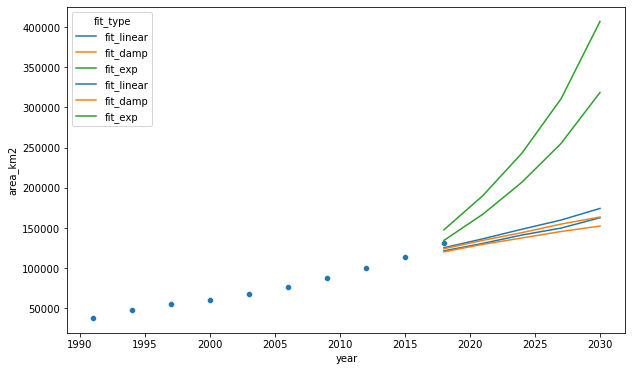

In [121]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=pix_count_df,x='year',y='area_km2')
sns.lineplot(data=fit_df,x='year',y='area_km2_low',hue='fit_type')
sns.lineplot(data=fit_df,x='year',y='area_km2_high',hue='fit_type')

In [122]:
# save data to disk
fit_df.to_csv('../Data/Result_csv/fit_df.csv',index=False)
fit_df = pd.read_csv('../Data/Result_csv/fit_df.csv')
fit_df

,year,pix_count_mean,pix_count_std,area_km2_mean,area_km2_std,fit_type,pix_count_low,pix_count_high,area_km2_low,area_km2_high
0,2018,1.371866e+08,1.099329e+07,123467.966837,9893.962610,fit_linear,1.350429e+08,1.393303e+08,121538.644128,125397.289546
1,2021,1.485269e+08,1.629685e+07,133674.198066,14667.160924,fit_linear,1.453490e+08,1.517048e+08,130814.101685,136534.294446
2,2024,1.609150e+08,2.055008e+07,144823.501554,18495.067967,fit_linear,1.569077e+08,1.649223e+08,141216.963301,148430.039808
3,2027,1.720451e+08,2.844601e+07,154840.591683,25601.405426,fit_linear,1.664981e+08,1.775921e+08,149848.317625,159832.865741
4,2030,1.872291e+08,3.311477e+07,168506.211834,29803.294806,fit_linear,1.807717e+08,1.936865e+08,162694.569347,174317.854321
5,2018,1.358341e+08,1.090600e+07,122250.673471,9815.398913,fit_damp,1.337074e+08,1.379608e+08,120336.670683,124164.676259
6,2021,1.468192e+08,1.420931e+07,132137.313759,12788.380421,fit_damp,1.440484e+08,1.495901e+08,129643.579577,134631.047942
7,2024,1.565264e+08,1.888594e+07,140873.757827,16997.350106,fit_damp,1.528436e+08,1.602092e+08,137559.274556,144188.241097
8,2027,1.668911e+08,2.635541e+07,150201.961754,23719.865245,fit_damp,1.617518e+08,1.720304e+08,145576.588031,154827.335477
9,2030,1.755781e+08,3.202866e+07,158020.293118,28825.796934,fit_damp,1.693325e+08,1.818237e+08,152399.262716,163641.323521
